# **2D Instance Segmentation pipeline**
___  

In this notebook, we demonstrate the use of the [BiaPy](https://biapy.readthedocs.io/en/latest/) pipeline for **2D instance segmentation** of microscopy data.

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/mitoem_crop.png' width='300px'/>
<img src='https://biapy.readthedocs.io/en/latest/_images/mitoem_crop_mask.png' width='300px'/>
<figcaption><b>Figure 1</b>: Example of a 2D instance segmentation problem. From left to right: 2D electron microscopy image and its corresponding mitochondria instance labels.</figcaption>
</center>
</figure>

Without any coding, we'll guide you step-by-step through the process to:
1. **Upload a set of training and test images** along with their corresponding instance label images.
2. **Train a Deep Neural Network (DNN)** model using the training set.
3. **Apply the model** to the test images.
4. **Download the segmentation results** to your local machine.

**Disclaimer:** The structure of the notebook is heavily inspired by the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

**Contact:** This notebook was created by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus) and [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org). For suggestions, comments, or issues, please reach out to us via email or [create an issue in BiaPy's repository](https://github.com/danifranco/BiaPy/issues). Thank you!


## **Expected inputs and outputs**
___
**Inputs**

This notebook expects five folders as input:
* **Training raw images**: with the raw 2D images to train the model.
* **Training label images**: with the instance-label 2D images to train the model. Their number and sizes must match those of the training raw images.
* **Test raw images**: with the raw 2D images to test the model.
* **Test label images** (optional): with the instance-label 2D images to test the model. Their number and sizes must match those of the validation raw images.
* **Output folder**: a path to store the segmentation results.

**Outputs**

Upon successful execution, a new folder will be generated containing one result **TIFF image** for every test image. These result images will showcase the instances of the objects of interest as determined by our pipeline.

<font color='red'><b>Note:</b></font> For testing, this notebook can be executed using the **example datasets found under 'Manage file(s) source > Option 3'**.

**Data structure**

To ensure the proper operation of the library the data directory tree should be something like this:

```
dataset/
├── train
│   ├── x
│   │   ├── training-0001.tif
│   │   ├── training-0002.tif
│   │   ├── . . .
│   │   ├── training-9999.tif
│   └── y
│       ├── training_groundtruth-0001.tif
│       ├── training_groundtruth-0002.tif
│       ├── . . .
│       ├── training_groundtruth-9999.tif
└── test
    ├── x
    │   ├── testing-0001.tif
    │   ├── testing-0002.tif
    │   ├── . . .
    │   ├── testing-9999.tif
    └── y
        ├── testing_groundtruth-0001.tif
        ├── testing_groundtruth-0002.tif
        ├── . . .
        ├── testing_groundtruth-9999.tif
```

**⚠️ Warning:** Ensure that images and their corresponding masks are sorted in the same way. A common approach is to fill with zeros the image number added to the filenames (as in the example).

**Input Format Support**

This notebook is compatible with a range of input formats. You can use the following file extensions: `.tif`, `.png`, `.jpg`, `.npy`, `.h5`, `.hdf5` (every extension supported by [scikit-image](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread)).




## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Check for GPU Access**
---

By default, the session is configured to use Python 3 with GPU acceleration. However, it's a good practice to double-check these settings:

1. Navigate to **Runtime** in the top menu and select **Change the Runtime type**.
2. Ensure the following settings:
   - **Runtime type:** Python 3 (This program is written in the Python 3 programming language.)
   - **Accelerator:** GPU (Graphics Processing Unit)

This will ensure that you're using Python 3 and taking advantage of GPU acceleration.


## **Manage File(s) Source**
---

The input folder can be provided using three different options:
1. **Direct Upload**: Directly upload the desired folder.
2. **Google Drive**: Use a folder stored in your Google Drive.
3. **Sample Data**: Use a sample dataset provided by us.

The steps you'll need to follow vary depending on your chosen option. These steps are detailed in the subsequent sections.


### **Option 1: Upload Files from Your Local Machine**
---

When you select this option, you'll be prompted to upload your files to Colab. Once uploaded, they will be stored in the `/content/input/` directory.


In [ ]:
#@markdown ##Play the cell to upload local files (train raw images)
from google.colab import files
!mkdir -p /content/input/train/x
%cd /content/input/train/x
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (train label images)

from google.colab import files
!mkdir -p /content/input/train/y
%cd /content/input/train/y
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (test raw images)

from google.colab import files
!mkdir -p /content/input/test/x
%cd /content/input/test/x
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (test label images)

from google.colab import files
!mkdir -p /content/input/test/y
%cd /content/input/test/y
uploaded = files.upload()
%cd /content

### **Option 2: Mount Your Google Drive**
---

If you wish to use this notebook with data from your Google Drive, you'll first need to mount the drive to this notebook.

Execute the cell below to initiate the Google Drive mounting process. A link will be displayed click on it. In the new browser window that opens, choose your drive and click 'Allow'. Copy the code that appears, return to this notebook, paste the code into the cell, and press 'Enter'. This action grants Colab access to your Google Drive data.

After this process, you can access your data via the **Files** tab, located on the top left of this notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: Download an Example Dataset**
---
Don't have data readily available but still want to test the notebook? No problem! Simply execute the following cell to download a sample dataset.


Specifically, we'll use the [ZeroCostDL4Mic - Stardist example training and test dataset](https://zenodo.org/record/3715492#.Y4m7FjPMJH6) which is publicly available online.

In [ ]:
#@markdown ##Play to download an example dataset

import os

os.chdir('/content/')

!curl -L -s -o Stardist_v2.zip 'https://drive.google.com/uc?id=1b7_WDDGEEaEoIpO_1EefVr0w0VQaetmg&confirm=t'

!unzip -q Stardist_v2.zip
!rm Stardist_v2.zip

print( 'Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data


## **Paths for Input Images and Output Files**
___

Depending on the option you chose for managing file sources, you'll set your paths differently:

- **Option 1 (Upload from Local Machine)**:
  - Set `train_data_path`: `/content/input/train/x`
  - Set `train_data_gt_path` `/content/input/train/y`
  - Set `test_data_path` `/content/input/test/x`
  - Set `test_data_gt_path` `/content/input/test/y`
  - Set `output_path` `/content/out`
  
- **Option 2 (Use Google Drive Data)**:
  - Insert the paths to your input files and your desired output directory here, i.e., `/content/gdrive/MyDrive/...`.
  
- **Option 3 (Use Our Sample Data)**:
  - Set `train_data_path`: `/content/data/train/x`
  - Set `train_data_gt_path` `/content/data/train/y`
  - Set `test_data_path` `/content/data/test/x`
  - Set `test_data_gt_path` `/content/data/test/y`
  - Set `output_path` `/content/out`

  **Note**: Ensure you download your results from the `/content/out` directory after the process!

**Helpful Tip**: If you're unsure about the paths to your folders, look at the top left of this notebook for a small folder icon. Navigate through the directories until you locate your desired folder. Right-click on it and select "Copy Path" to copy the folder's path.

In [ ]:
#@markdown #####Path to train images
train_data_path = '/content/data/train/x' #@param {type:"string"}
#@markdown #####Path to train instances
train_data_gt_path = '/content/data/train/y' #@param {type:"string"}
#@markdown #####Path to test images
test_data_path = '/content/data/test/x' #@param {type:"string"}
#@markdown #####Path to test instances (optional)
test_data_gt_path = '/content/data/test/y' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Install BiaPy library**


In [ ]:
#@markdown ##Play to install BiaPy and its dependences

import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
from skimage.exposure import match_histograms

# Clone the repo
os.chdir('/content/')
if not os.path.exists('BiaPy'):
    !git clone --depth 1 https://github.com/danifranco/BiaPy.git
    !pip install --upgrade --no-cache-dir gdown &> /dev/null
    sys.path.insert(0, 'BiaPy')
    os.chdir('/content/BiaPy')

    # Install dependencies
    !pip install biapy==3.1.0.1
else:
    print( 'Using existing installed version of BiaPy' )

Cloning into 'BiaPy'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 150 (delta 40), reused 53 (delta 14), pack-reused 0
Receiving objects: 100% (150/150), 26.36 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Obtaining file:///content/BiaPy
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## **Configure and Train the DNN Model**
---

[BiaPy](https://biapy.readthedocs.io/en/latest/) adopts a bottom-up approach to both 2D and 3D instance segmentation. It learns the binary masks, contours (or center points), and (optionally) the distance map of the objects of interest. These learned elements are later post-processed using marker-controlled watershed as detailed in [Wei et al. 2020](https://link.springer.com/chapter/10.1007/978-3-030-59722-1_7).

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/cysto_instance_bcd_scheme.svg' width='300px'/>
<figcaption><b>Figure 2</b>: Multi-channel representation for instance segmentation. Label instances are deduced by predicting their contours, binary masks, and distance maps as described in <a href="https://link.springer.com/chapter/10.1007/978-3-030-59722-1_7">Wei et al. 2020</a>.</figcaption></center>
</figure>

To configure these representations and other pipeline hyperparameters, you can either edit the YAML configuration file directly or, more simply, execute the following cell.


### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

#### **Data management**
* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

* **`test_ground_truth`:** Select to use test data ground truth to measure the performance of the model's result. If selected, **test_data_gt_path** variable path set above will be used. **Default value: True**

#### **Basic training parameters**
* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. For the example dataset, reasonable results can already be observed after 100 epochs. **Default value: 100**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 20**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:** Select the architecture of the DNN used as backbone of the pipeline. Options: U-Net, Residual U-Net, Attention U-Net, SEUNet, MultiResUNet, ResUNet++ (see [Franco-Barranco et al., 2021](https://link.springer.com/article/10.1007/s12021-021-09556-1)), UNETR-Mini, UNETR-Small and UNETR-Base.  **Default value: U-Net**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 8**

* **`patch_size`:** Input the size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 256**

* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 1**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, ADAMW, Stochastic Gradient Descent (SGD). ADAM usually converges faster, while ADAMW provides a balance between fast convergence and better handling of weight decay regularization. SGD is known for better generalization.**Default value: ADAMW**
* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM or ADAMW as optimizer, this value should be around 10e-4. **Default value: 0.0001**

* **`problem_representation`:** Select the type of representation that the model must learn to identify the instances. Options: "Binary mask + Contours", "Binary mask + Central points", "Binary mask + Contours + Distance map", "Binary mask + Contours + Foreground mask" (see <a href="https://link.springer.com/chapter/10.1007/978-3-030-59722-1_7">Wei et al. 2020</a>). **Default value: "Binary mask + Contours"**

* **`test_time_augmentation`:** Select to apply augmentation (flips and rotations) at test time. It usually provides more robust results but uses more time to produce each result. **Default value: False**

In [ ]:
#@markdown ###Name of the model:
model_name = "my_2d_instance_segmentation" #@param {type:"string"}

#@markdown ### Data management:
test_ground_truth = True #@param {type:"boolean"}
percentage_validation =  10 #@param {type:"number"}

#@markdown ### Basic training parameters:
number_of_epochs =  100#@param {type:"number"}
patience =  20#@param {type:"number"}

#@markdown ### Advanced training parameters:

model_architecture = "U-Net" #@param ["U-Net", "Residual U-Net", "Attention U-Net", 'MultiResUNet', 'ResUNet++', 'SEUNet', "UNETR-Mini","UNETR-Small", "UNETR-Base"]
batch_size =  8#@param {type:"number"}
patch_size = 256 #@param {type:"number"}
input_channels = 1 #@param {type:"number"}
optimizer = "ADAMW" #@param ["ADAM", "SGD","ADAMW"]
initial_learning_rate = 0.0001 #@param {type:"number"}
problem_representation = "Binary mask + Contours" #@param ["Binary mask + Contours", "Binary mask + Central points", "Binary mask + Distance map","Binary mask + Contours + Distance map", "Binary mask + Contours + Foreground mask", "Binary mask + Contours + Distance map with background", "Distance map with background"]
learning_rate_scheduler = "None" #@param ["None", "Reduce on plateau","One cycle", "Warm-up cosine decay"]
test_time_augmentation = False #@param {type:"boolean"}

checkpoint_path = ''

In [ ]:
#@markdown ##OPTIONAL: Play the cell to upload initial model weights
#@markdown Use this option to start the training from a **pre-trained model** if you have one. Otherwise, skip this cell.

#@markdown **Important**: remember the weights must correspond to the selected architecture, patch size and number of input channels. Otherwise, an error will be shown when training.
from google.colab import files

#s.chdir('/content/')

uploaded = files.upload()

checkpoint_path = '/content/' + list(uploaded.keys())[0]

# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['PATHS'] = {}
biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")


In [ ]:
#@markdown ##Play to download the YAML configuration file and update it to train the model

import os
import errno

os.chdir('/content/')

job_name = model_name

yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = '2d_instance_segmentation.yaml'

if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file
import shutil
!wget https://raw.githubusercontent.com/danifranco/BiaPy/master/templates/instance_segmentation/2d_instance_segmentation.yaml &> /dev/null

#/content/BiaPy/templates/instance_segmentation/2d_instance_segmentation.yaml
# Check folders before modifying the .yaml file
if not os.path.exists(train_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_path)
ids = sorted(next(os.walk(train_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(train_data_path))
if not os.path.exists(train_data_gt_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_gt_path)
ids = sorted(next(os.walk(train_data_gt_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(train_data_gt_path))

# Check folders before modifying the .yaml file
if not os.path.exists(test_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_path)
ids = sorted(next(os.walk(test_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(test_data_path))
if test_ground_truth:
    if not os.path.exists(test_data_gt_path):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_gt_path)
    ids = sorted(next(os.walk(test_data_gt_path))[2])
    if len(ids) == 0:
        raise ValueError("No images found in dir {}".format(test_data_gt_path))


# open template configuration file
import yaml
with open( '2d_instance_segmentation.yaml', 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['DATA'] = {}
biapy_config['DATA']['TRAIN'] = {}
biapy_config['DATA']['TRAIN'] ['PATH']= {}
biapy_config['DATA']['TEST'] = {}
biapy_config['DATA']['TEST']['PATH'] = {}
biapy_config['DATA']['TRAIN']['PATH'] = train_data_path
biapy_config['DATA']['TRAIN']['GT_PATH'] = train_data_gt_path
biapy_config['DATA']['TEST']['PATH'] = test_data_path
biapy_config['DATA']['TEST']['GT_PATH'] = test_data_gt_path

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size)+', '+ str(patch_size)+', ' + str(input_channels)+')'
# adjust test padding accordingly
padding = patch_size // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+str(padding)+', '+ str(padding)+')'

# update training parameters
biapy_config['DATA']['VAL'] = {}
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']={}
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate
biapy_config['TRAIN']['ENABLE'] = True


# Transcribe problem representation
#   BC = "Binary mask + Contours"
#   BCM = "Binary mask + Contours + Foreground mask"
#   BCD = "Binary mask + Contours + Distance map"
#   BCDv2 = "Binary mask + Contours + Distance map with background"
#   Dv2 = "Distance map with background"
#   BDv2 = "Binary mask + Distance map with background"
#   BP = "Binary mask + Central points"
#   BD = "Binary mask + Distance map"
problem_channels = 'BC'
if problem_representation == "Binary mask + Contours":
    problem_channels = 'BC'
elif problem_representation == "Binary mask + Central points":
    problem_channels = 'BP'
elif problem_representation == "Binary mask + Distance map":
    problem_channels = 'BD'
elif problem_representation == "Binary mask + Contours + Foreground mask":
    problem_channels = 'BCM'
elif problem_representation == "Binary mask + Contours + Distance map":
    problem_channels = 'BCD'
elif problem_representation == "Binary mask + Contours + Distance map with background":
    problem_channels = 'BCDv2'
elif problem_representation == "Distance map with background":
    problem_channels = 'Dv2'
else:
    problem_channels = 'BDv2'

biapy_config['PROBLEM']['INSTANCE_SEG']['DATA_CHANNELS'] = problem_channels
biapy_config['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_TYPE'] = "auto"

# Transcribe model architecture
# Available models: "U-Net", "Residual U-Net", "Attention U-Net",
# 'MultiResUNet', 'SEUNet', 'ResUNet++', "UNETR-Mini","UNETR-Small"
# "UNETR-Base"
architecture = 'unet'
if model_architecture == "U-Net":
    architecture = 'unet'
elif model_architecture == "Residual U-Net":
    architecture = 'resunet'
elif model_architecture == "Attention U-Net":
    architecture = 'attention_unet'
elif model_architecture == "MultiResUNet":
    architecture = 'multiresunet'
elif model_architecture == "ResUNet++":
    architecture = 'resunet++'
elif model_architecture == "SEUNet":
    architecture = 'seunet'
elif model_architecture == "UNETR-Mini":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 64
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 4
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 4. # to get 256
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 4
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 1
    biapy_config['TEST']['STATS']['FULL_IMG'] = False
elif model_architecture == "UNETR-Small":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 128
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 8
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 4. # to get 512
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 8
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 2
    biapy_config['TEST']['STATS']['FULL_IMG'] = False
else: # UNETR-Base
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 256
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 12
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 3. # to get 768
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 12
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 3
    biapy_config['TEST']['STATS']['FULL_IMG'] = False

biapy_config['MODEL']['ARCHITECTURE'] = architecture

# update test parameters
biapy_config['TEST']['AUGMENTATION'] = test_time_augmentation
biapy_config['DATA']['TEST']['LOAD_GT'] = test_ground_truth
biapy_config['TEST']['ENABLE'] = True

# model weights
if checkpoint_path != '':
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

Training configuration finished.


### **Train the model**
---

In [ ]:
#@markdown ##Play to train the model
# Run the code
os.chdir('/content/BiaPy')
!python -u main.py --config '/content/'{job_name}'.yaml' --result_dir {output_path} --name {job_name} --run_id 1 --gpu 0


Date: 2023-10-10 07:39:14
Arguments: Namespace(config='/content/my_2d_instance_segmentation.yaml', result_dir='/content/output', name='my_2d_instance_segmentation', run_id=1, gpu='0', world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
Job: my_2d_instance_segmentation_1
Python       : 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
PyTorch:  2.0.1+cu118
Not using distributed mode
[07:39:14.347921] Configuration details:
[07:39:14.347980] AUGMENTOR:
  AFFINE_MODE: constant
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_EM: False
  BRIGHTNESS_EM_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_EM_MODE: 3D
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_EM: False
  CONTRAST_EM_FACTOR: (-0.1, 0.1)
  C

## **Inspection of the Loss Function and the Intersection over Union (IoU)**
---

Before proceeding with interpretations, it's pivotal to gauge the training evolution by juxtaposing the training loss against the validation loss. The validation loss casts light on the model's efficacy over a reserved subset of data unseen during training. A deeper understanding can be garnered from [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

- **Training Loss**: This captures the discrepancy between the model's predictions and the actual ground-truth after each epoch.

- **Validation Loss**: This signifies the error between the model's estimates on validation images and their actual counterparts.

As training unfurls, these metrics are expected to wane, eventually plateauing at an optimal, minimal value. Contrasting the trajectories of these losses can yield vital information about the model's adaptability.

- **Decreasing Training and Validation Losses**: This trend is indicative of potential model improvements with further training. Elevating the `number_of_epochs` is advised in such scenarios. Notably, even if the loss curves seem to stabilize towards the tail end, it might be a mere visual effect due to y-axis scaling. The model is considered convergent once the curves genuinely flatten, marking the end of required training.

- **Divergent Losses**: An upward tick in validation loss while training loss gravitates towards zero hints at overfitting. It suggests that the model is intricately memorizing training patterns at the cost of broader applicability. A more substantial training dataset can alleviate this.

The **Jaccard Index, also known as the Intersection over Union (IoU)**, offers a means to evaluate the overlap between the target mask and prediction. **A score inching towards 1 denotes optimal performance.** It's a handy metric to gauge the precision of your model in predicting cellular structures.


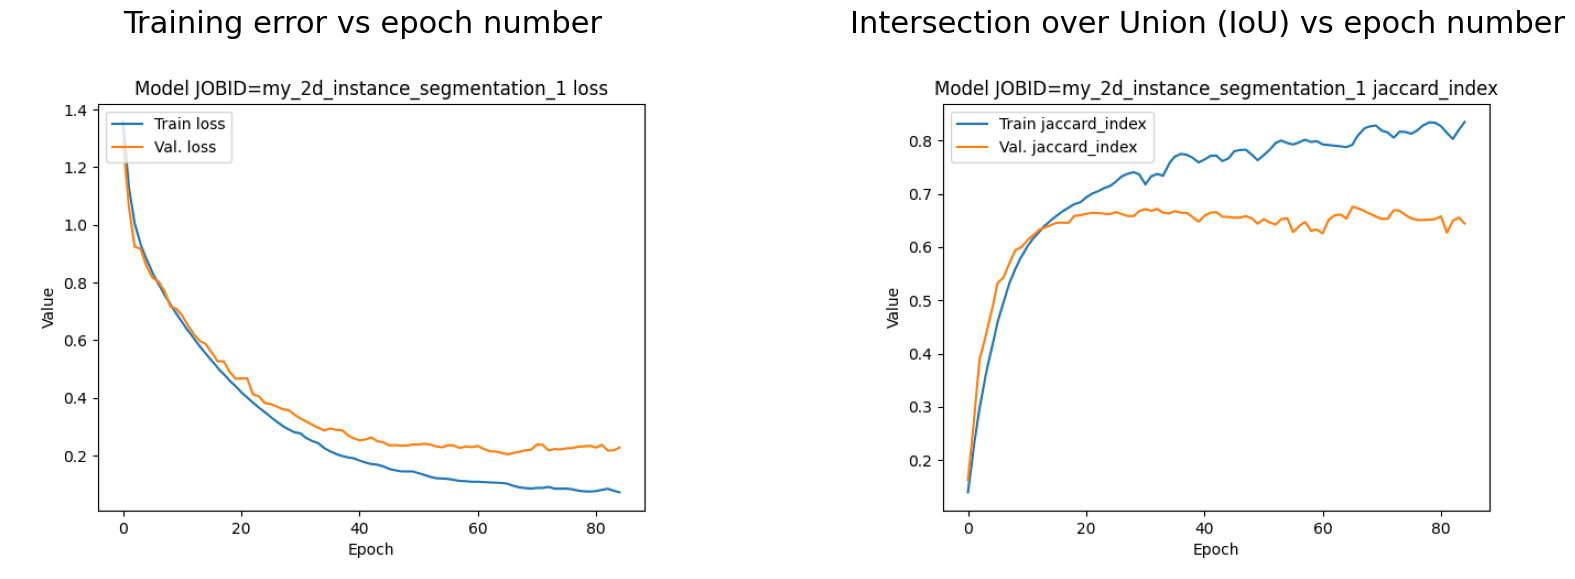

In [ ]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and IoU vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

iou_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_jaccard_index.png' )

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( iou_plot )
_ = plt.axis('off')
_= ax2.set_title( 'Intersection over Union (IoU) vs epoch number', fontdict = {'fontsize':22})

## **Visualize instance segmentation results (from the test set)**


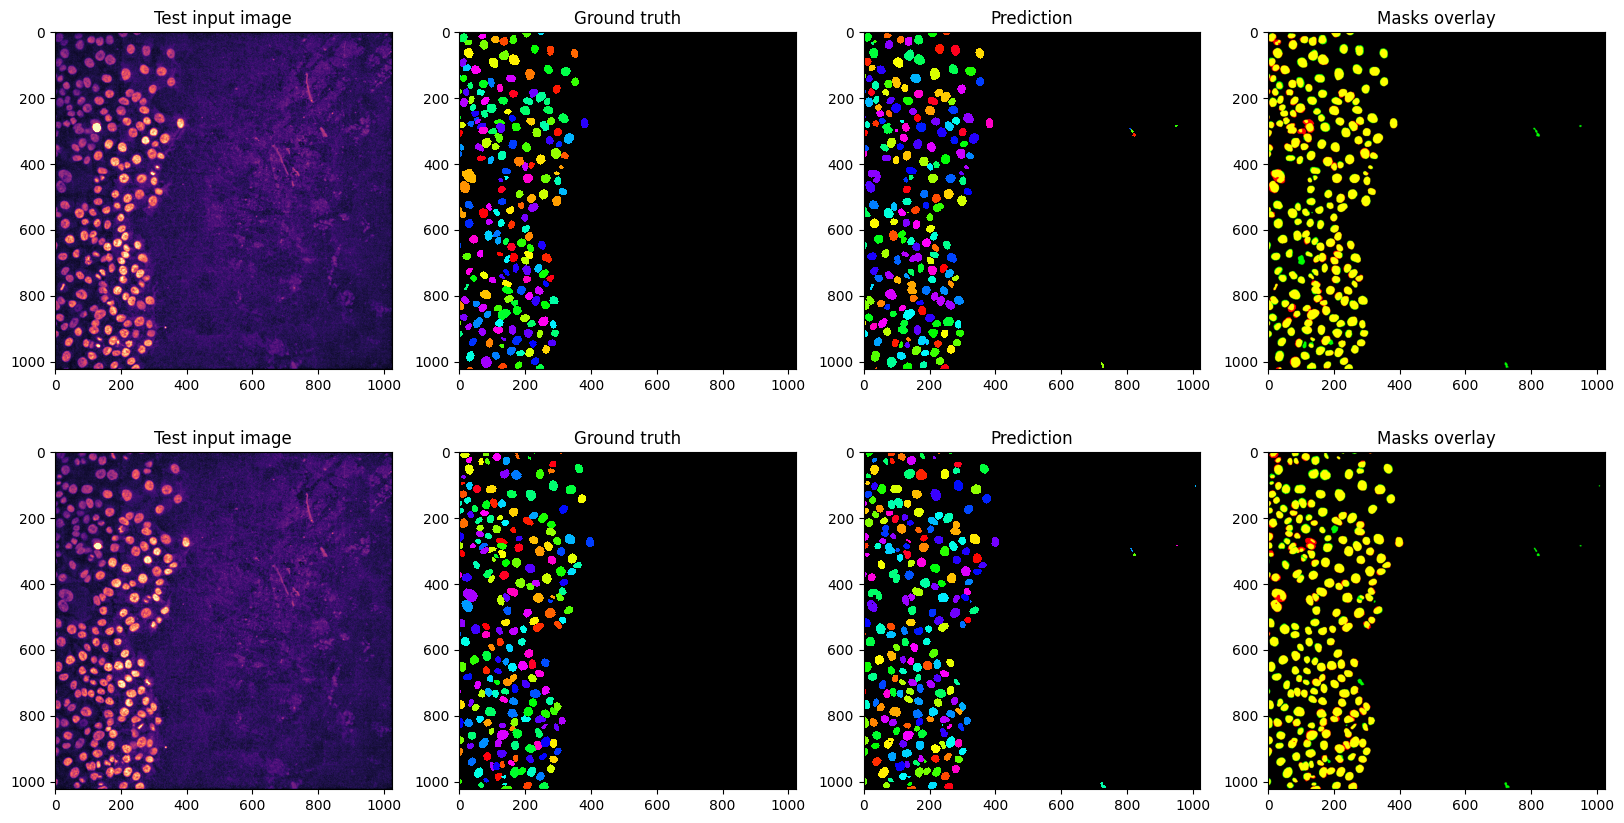

In [ ]:
final_results = os.path.join(output_path, job_name, 'results', job_name + "_1")
instance_results = os.path.join(final_results, "per_image_instances")

#@markdown ##Play to visualize some results from the test set
#@markdown The current model will be applied to some test images and results will be shown displaying:
#@markdown 1. The original **Test input image**
#@markdown 2. Its corresponding **Ground truth** labels
#@markdown 3. The model **Prediction** labels
#@markdown 4. The **Masks overlay** (true positive pixels in yellow, false negative pixels in red, and false positive pixels in green).

from IPython.display import Markdown as md
md("After this last step, the resulting images should be placed in {}".format(final_results))
# Show a few examples to check that they have been stored correctly
%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt

ids_pred = sorted(next(os.walk(instance_results))[2])
ids_input = sorted(next(os.walk(test_data_path))[2])
ids_gt = sorted(next(os.walk(test_data_gt_path))[2])

# create random color map
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_rainbow(vals))
cmap.colors[0] = [0., 0., 0., 1.] # set background to black

samples_to_show = min(len(ids_input), 3)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False)
seed(1)

test_samples = []
test_sample_preds = []
test_sample_gt = []

for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_data_path, ids_input[chosen_images[i]]))
    test_samples.append(aux)

    aux = imread(os.path.join(instance_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(aux)

    aux = imread(os.path.join(test_data_gt_path, ids_gt[chosen_images[i]])).astype(np.uint16)
    test_sample_gt.append(aux)

# Show predicted images
plt.figure(figsize=(20,10))
index = 1
for j in range(samples_to_show):
    plt.subplot(samples_to_show, 4, index)
    plt.title("Test input image")
    plt.imshow(test_samples[j], cmap='magma', vmin=np.percentile(test_samples[j],0.1),vmax=np.percentile(test_samples[j],99.9))

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Ground truth")
    plt.imshow(test_sample_gt[j],  cmap=cmap, interpolation='nearest')

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Prediction")
    plt.imshow(test_sample_preds[j], cmap=cmap, interpolation='nearest')

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Masks overlay")
    b = np.zeros( test_sample_gt[j].shape )
    overlay = np.dstack( (test_sample_gt[j]>0, test_sample_preds[j]>0, b ))
    plt.imshow( overlay )

    index = index + 1
plt.show()


In [ ]:
#@markdown ###Play to display the path to the output files (one 2D TIFF label image for each input image).

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

instance_results = os.path.join(final_results, "per_image_instances")

print("Output paths:")
print("    Instance segmentation files are in {}".format(instance_results))

Output paths:
    Instance segmentation files are in /content/output/my_2d_instance_segmentation/results/my_2d_instance_segmentation_1/per_image_instances


## **Download instance segmentation results**

In [ ]:
#@markdown ###Play to download a zip file with all instance segmentation results in test.

from google.colab import files

!zip -q -j /content/instance_segmentation_results.zip $instance_results/*.tif

files.download("/content/instance_segmentation_results.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Download train model (weights and configuration file)**
If you want to **reuse the train model in the future**, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [ ]:
from google.colab import files

#@markdown ###Play to download the model weights

checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = str( job_name ) + '_1-checkpoint-best.pth'

files.download( os.path.join( checkpoints_path, weights_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download the model configuration file (.YAML)

config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Advanced options**

### **Adjust marker-controlled watershed threshold values**

In [ ]:
#@markdown ### Marker-controlled watershed parameters:
binary_mask_seed_threshold =  0.99#@param {type:"number"}
binary_mask_grow_threshold =  0.4#@param {type:"number"}
contour_threshold =  0.2 #@param {type:"number"}
central_point_threshold =  0.1 #@param {type:"number"}
distance_seed_threshold =  1.1 #@param {type:"number"}


### **Run inference**

In [ ]:
#@markdown ### Play to run inference on test with the new parameters

# Transcribe model architecture

biapy_config_inference = biapy_config

# set the training to false to peform inference
biapy_config_inference['TRAIN']['ENABLE'] = False

biapy_config_inference['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_TYPE'] = "manual"
biapy_config_inference['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_BINARY_MASK'] = binary_mask_seed_threshold
biapy_config_inference['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_CONTOUR'] = contour_threshold
biapy_config_inference['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_POINTS'] = central_point_threshold
biapy_config_inference['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_FOREGROUND'] = binary_mask_grow_threshold
biapy_config_inference['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_DISTANCE'] = distance_seed_threshold

# save file
inference_file = "/content/"+str(job_name)+"_inference.yaml"

with open( inference_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Inference configuration finished.")

# Run the code
os.chdir('/content/BiaPy')
!python -u main.py --config '/content/'{job_name}'_inference.yaml' --result_dir {output_path} --name {job_name} --run_id 1 --gpu 0

Inference configuration finished.
Date: 2023-10-10 07:55:24
Arguments: Namespace(config='/content/my_2d_instance_segmentation_inference.yaml', result_dir='/content/output', name='my_2d_instance_segmentation', run_id=1, gpu='0', world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
Job: my_2d_instance_segmentation_1
Python       : 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
PyTorch:  2.0.1+cu118
Not using distributed mode
[07:55:24.667073] Configuration details:
[07:55:24.667122] AUGMENTOR:
  AFFINE_MODE: constant
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_EM: False
  BRIGHTNESS_EM_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_EM_MODE: 3D
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_EM:

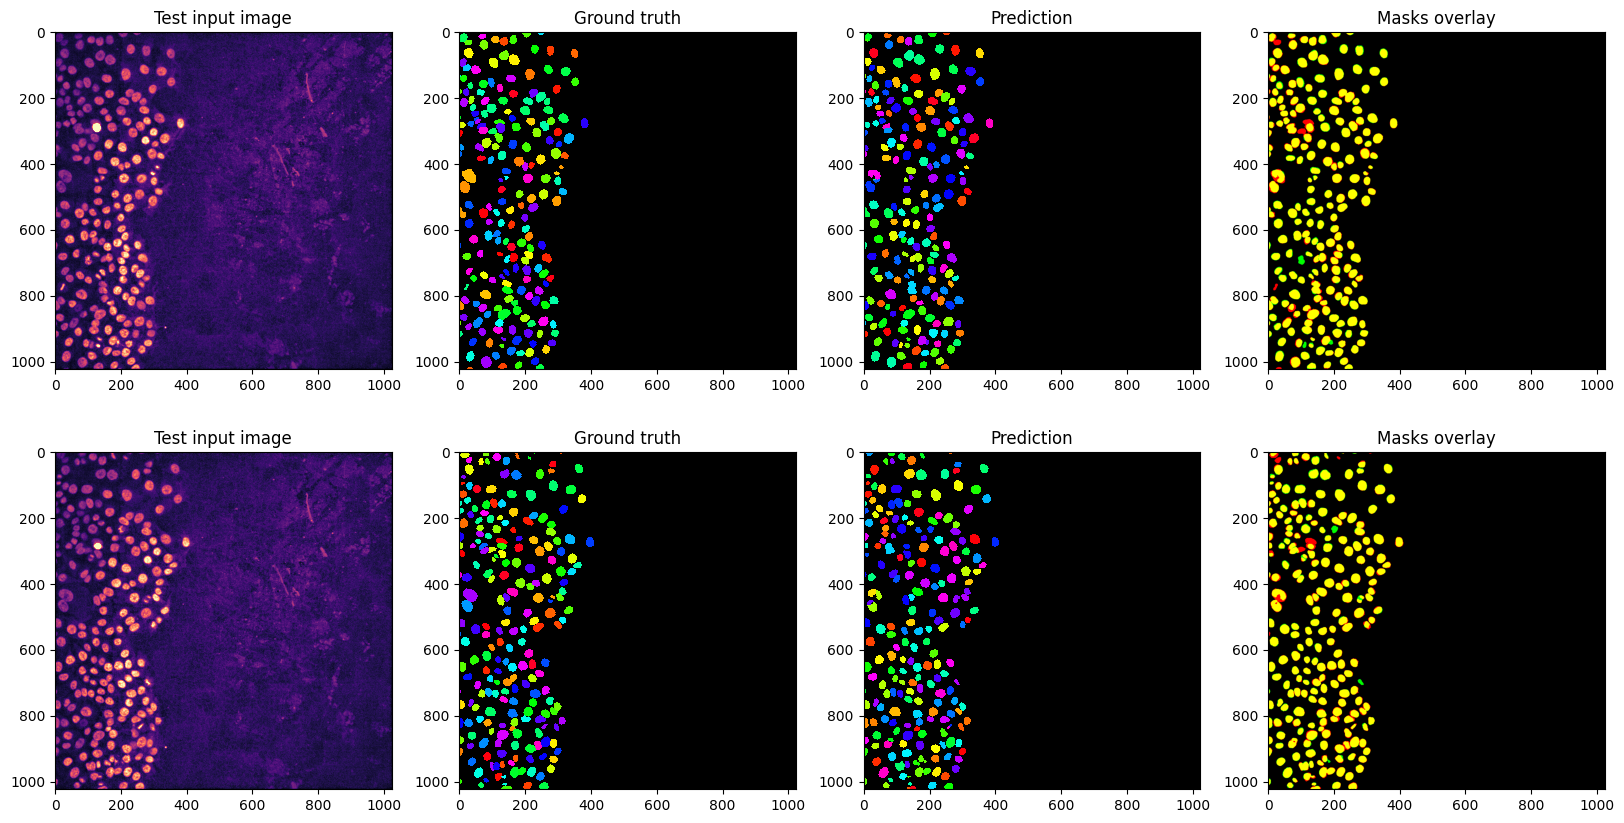

In [ ]:
#@markdown ##Play to visualize some results from the test set
#@markdown The current model will be applied to some test images and results will be shown displaying:
#@markdown 1. The original **Test input image**
#@markdown 2. Its corresponding **Ground truth** labels
#@markdown 3. The model **Prediction** labels
#@markdown 4. The **Masks overlay** (true positive pixels in yellow, false negative pixels in red, and false positive pixels in green).

test_samples = []
test_sample_preds = []
test_sample_gt = []

for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_data_path, ids_input[chosen_images[i]]))
    test_samples.append(aux)

    aux = imread(os.path.join(instance_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(aux)

    aux = imread(os.path.join(test_data_gt_path, ids_gt[chosen_images[i]])).astype(np.uint16)
    test_sample_gt.append(aux)

# Show predicted images
plt.figure(figsize=(20,10))
index = 1
for j in range(samples_to_show):
    plt.subplot(samples_to_show, 4, index)
    plt.title("Test input image")
    plt.imshow(test_samples[j], cmap='magma', vmin=np.percentile(test_samples[j],0.1),vmax=np.percentile(test_samples[j],99.9))

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Ground truth")
    plt.imshow(test_sample_gt[j],  cmap=cmap, interpolation='nearest')

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Prediction")
    plt.imshow(test_sample_preds[j], cmap=cmap, interpolation='nearest')

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Masks overlay")
    b = np.zeros( test_sample_gt[j].shape )
    overlay = np.dstack( (test_sample_gt[j]>0, test_sample_preds[j]>0, b ))
    plt.imshow( overlay )

    index = index + 1
plt.show()


## **Acknowledgments**

We extend our gratitude to the [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki) for their invaluable inspiration. Notably, we have adopted some of their descriptions concerning metrics and parameters.
